In [64]:
import pandas as pd
import matplotlib.pyplot as plt

In [65]:
# map likert to numeric values
def likert_to_numeric(likert_value):
    likert_map = {
        "Strongly Disagree": 1,
        "Strongly disagree": 1,
        "Disagree": 2,
        "Neither agree or disagree": 3,
        "Agree": 4,
        "Strongly Agree": 5
    }
    return likert_map.get(likert_value, None)

In [66]:
# replace godspeed entries that have  1 or 5 in the string with just 1 and 5
def replace_godspeed(value):
    if isinstance(value, str):
        if '1' in value:
            return 1
        elif '5' in value:
            return 5
    return value

In [67]:
# Load all the data
pre_task = pd.read_csv('data/preTask.csv')
post_task = pd.read_csv('data/postTask.csv')

task = pd.read_csv('data/task.csv')

pre_task = pre_task.iloc[2:]
post_task = post_task.iloc[2:]

pre_task.reset_index(drop=True, inplace=True)
post_task.reset_index(drop=True, inplace=True)

failed_attention_check = set()

# convert preTask to usable format
pre_task_cols = ['ResponseID', 'Q1', 'Q3', 'Q4', 'Q7_1', 'Q7_2', 'Q7_3', 'Q7_4', 'Q7_5', 'Q7_6', 'Q8_1', 'Q8_2', 'Q8_3', 'Q8_4']

trust_pretask = ['trust_operate', 'trust_comfort', 'trust_depend', 'trust_cautious', 'trust_trustworthy', 'attention_check_disagree']
familiar_pretask = ['familiar_1', 'familiar_2', 'familiar_3', 'familiar_4']
pre_task_col_names = ['user_id', 'consent', 'gender', 'age'] + trust_pretask + familiar_pretask

pre_task = pre_task[pre_task_cols]
pre_task.columns = pre_task_col_names

# convert postTask to usable format
post_task_cols = ['uid', 'Q11', 'Q12', 'Q13', 'Q14', 'Q15', 'Q16_1', 'Q16_2', 'Q16_3', 'Q16_4', 'Q16_5', 'Q16_6']

anthropomorphism_godscale = ['godspeed_fake', 'godspeed_machinelike', 'godspeed_unconscious', 'godspeed_artificial', 'godspeed_rigid']
anthropomorphism_likert = ['likert_emotion', 'likert_humanlike', 'likert_style', 'likert_intentional', 'likert_another_person', 'attention_check_strongly_agree']

post_task_cols_names = ['user_id'] + anthropomorphism_godscale + anthropomorphism_likert

post_task = post_task[post_task_cols]
post_task.columns = post_task_cols_names

In [68]:
# map trust_pretask and familiar_pretask to numeric values
for col in trust_pretask + familiar_pretask:
    pre_task[col] = pre_task[col].apply(likert_to_numeric)
    pre_task[col] = pd.to_numeric(pre_task[col], errors='coerce')

# reverse code trust_cautious
pre_task['trust_cautious'] = pre_task['trust_cautious'].apply(lambda x: 6 - x if pd.notnull(x) else x)
    
# final_trust score is the average of trust_pretask columns
pre_task['final_trust'] = pre_task[trust_pretask].mean(axis=1)
# final_familiar score is the average of familiar_pretask columns
pre_task['final_familiar'] = pre_task[familiar_pretask].mean(axis=1)

# check if attention check is passed (equals to 2)
pre_task['pre_task_attention'] = pre_task['attention_check_disagree'] == 2

# print the number of participants who failed the attention check
print(f"Number of participants who failed the pretask attention check: {len(pre_task[~pre_task['pre_task_attention']])}")

#filter out participants who failed the attention check after adding them to the failed_attention_check list (user id)
failed_attention_check.update(pre_task[~pre_task['pre_task_attention']]['user_id'])
pre_task = pre_task[pre_task['pre_task_attention']]

pre_task.reset_index(drop=True, inplace=True)

Number of participants who failed the pretask attention check: 1


In [69]:
for col in anthropomorphism_godscale:
    post_task[col] = post_task[col].apply(replace_godspeed)
    post_task[col] = pd.to_numeric(post_task[col], errors='coerce')
    
for col in anthropomorphism_likert:
    post_task[col] = post_task[col].apply(likert_to_numeric)
    post_task[col] = pd.to_numeric(post_task[col], errors='coerce')

# check if attention check is passed (equals to 5)
post_task['post_task_attention'] = post_task['attention_check_strongly_agree'] == 5

print(f"Number of participants that failed the post-task attention check: {len(post_task[~post_task['post_task_attention']])}")

# filter out participants who failed the attention check after adding them to the failed_attention_check list (user id)
failed_attention_check.update(post_task[~post_task['post_task_attention']]['user_id'])
post_task = post_task[post_task['post_task_attention']] 

# merge pre_task and post_task on user_id
pre_post_task = pd.merge(pre_task, post_task, on='user_id', how='inner')

print("Number of participants failing any attention check:", len(failed_attention_check))
print(f"Number of participants who passed the attention check: {len(pre_post_task)}")

Number of participants that failed the post-task attention check: 1
Number of participants failing any attention check: 2
Number of participants who passed the attention check: 18


In [70]:
# now merge with task data
scenarios = ['Interpersonal Relations and Self-Concept', 'Tastes and Interests', 'Work or Studies']
sensitivity = ['Low', 'Medium', 'High']
willingness = [1, 2, 3, 4, 5]

task_cols = ['user_id', 'condition', 'study', 'scenario', 'question', 'question_sensitivity', 'user_willingness', 'user_sensitivity']

# compute for each condition the average willingness and sensitivity
task = task[task_cols]

In [71]:
df = pd.merge(pre_post_task, task, on='user_id', how='inner')

df['final_anthropomorphism'] = df[anthropomorphism_godscale + anthropomorphism_likert].mean(axis=1)

display(df)
df.to_csv('results/merged_data.csv', index=False)

,user_id,consent,gender,age,trust_operate,trust_comfort,trust_depend,trust_cautious,trust_trustworthy,attention_check_disagree,...,attention_check_strongly_agree,post_task_attention,condition,study,scenario,question,question_sensitivity,user_willingness,user_sensitivity,final_anthropomorphism
0,R_8nuec0oZkEBN4WT,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,...,5,True,1,sagar,Interpersonal Relations and Self-Concept,Do you ever feel a sense of loss or longing wh...,Low,4,Low,2.636364
1,R_8nuec0oZkEBN4WT,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,...,5,True,1,sagar,Interpersonal Relations and Self-Concept,Have past experiences in relationships ever le...,High,5,Low,2.636364
2,R_8nuec0oZkEBN4WT,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,...,5,True,1,sagar,Interpersonal Relations and Self-Concept,What is something you've done recently that ma...,Medium,2,Low,2.636364
3,R_8nuec0oZkEBN4WT,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,...,5,True,1,sagar,Tastes and Interests,What types of social environments do you find ...,Low,4,Low,2.636364
4,R_8nuec0oZkEBN4WT,"I consent, begin the study",Male,21 - 25,4,2,4,3,4,2,...,5,True,1,sagar,Tastes and Interests,Have you ever felt emotionally triggered by pe...,High,4,Low,2.636364
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,R_8fiMKMqkVpE3Z4t,"I consent, begin the study",Male,21 - 25,4,4,4,4,4,2,...,5,True,2,sagar,Tastes and Interests,Have you ever felt emotionally triggered by pe...,High,5,High,4.818182
158,R_8fiMKMqkVpE3Z4t,"I consent, begin the study",Male,21 - 25,4,4,4,4,4,2,...,5,True,2,sagar,Tastes and Interests,"Are there certain types of music, shows, or st...",Medium,4,Low,4.818182
159,R_8fiMKMqkVpE3Z4t,"I consent, begin the study",Male,21 - 25,4,4,4,4,4,2,...,5,True,2,sagar,Work or Studies,What personal strengths do you draw on to stay...,Low,5,Low,4.818182
160,R_8fiMKMqkVpE3Z4t,"I consent, begin the study",Male,21 - 25,4,4,4,4,4,2,...,5,True,2,sagar,Work or Studies,Have you been feeling any stress or mental fat...,Medium,4,Medium,4.818182


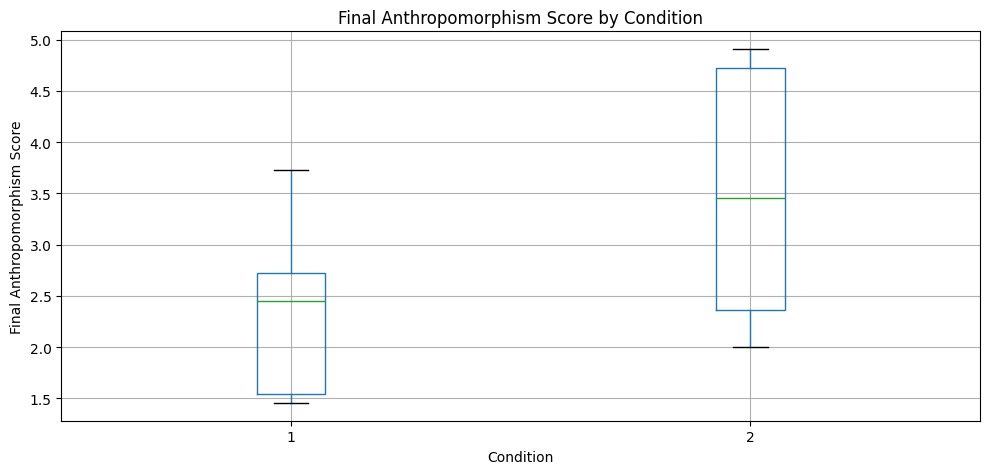

In [72]:
# display the box plot of the final anthropomorphism score by condition
fig4, ax4 = plt.subplots(figsize=(10, 5))
df.boxplot(column='final_anthropomorphism', by='condition', ax=ax4)
ax4.set_title('Final Anthropomorphism Score by Condition')
ax4.set_xlabel('Condition')
ax4.set_ylabel('Final Anthropomorphism Score')
plt.suptitle('')
plt.tight_layout()
plt.show()

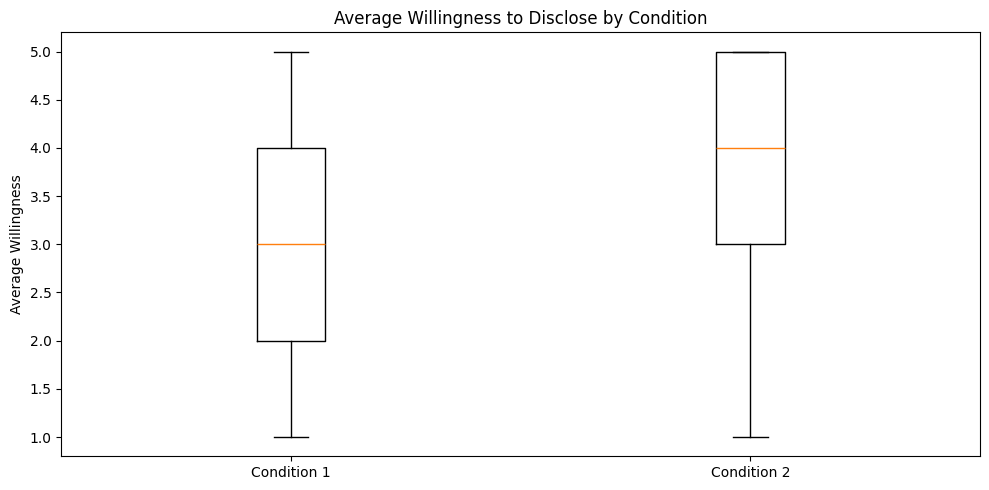

In [73]:
# First plot: Willingness by condition
fig1, ax1 = plt.subplots(figsize=(10, 5))
ax1.boxplot(
    [df[df['condition'] == 1]['user_willingness'],
     df[df['condition'] == 2]['user_willingness']],
    tick_labels=['Condition 1', 'Condition 2']
)
ax1.set_title('Average Willingness to Disclose by Condition')
ax1.set_ylabel('Average Willingness')
plt.tight_layout()
plt.show()

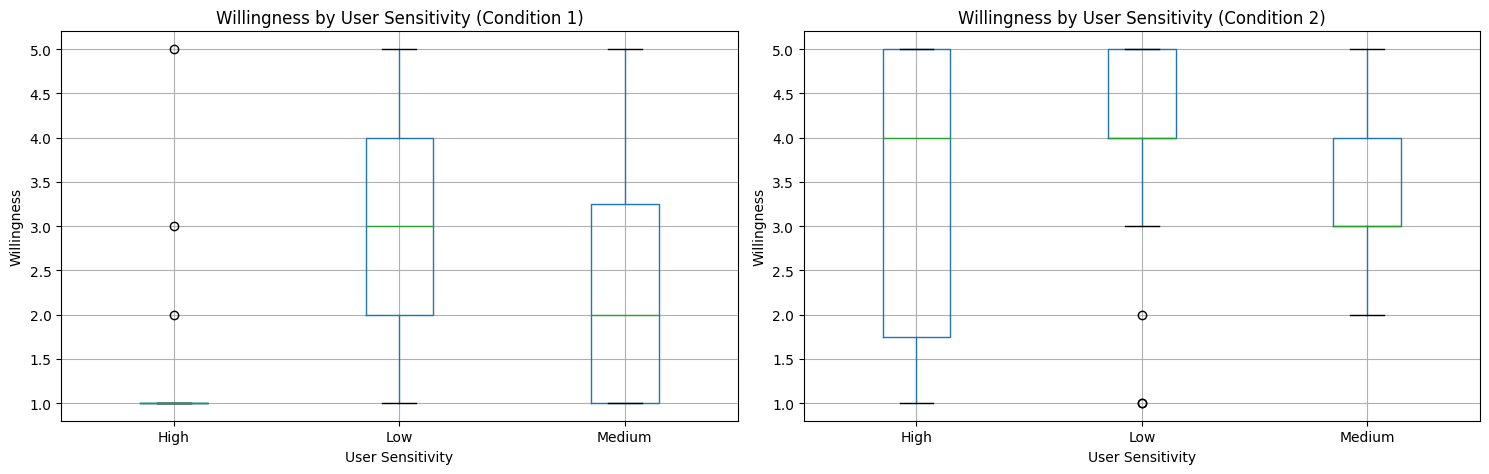

In [74]:
# Second plot: Willingness by sensitivity for each condition
fig2, axes2 = plt.subplots(1, 2, figsize=(15, 5))

# Boxplot for willingness by sensitivity for condition 1
df[df['condition'] == 1].boxplot(column='user_willingness', by='user_sensitivity', ax=axes2[0])
axes2[0].set_title('Willingness by User Sensitivity (Condition 1)')
axes2[0].set_xlabel('User Sensitivity')
axes2[0].set_ylabel('Willingness')
axes2[0].get_figure().suptitle('')

# Boxplot for willingness by sensitivity for condition 2
df[df['condition'] == 2].boxplot(column='user_willingness', by='user_sensitivity', ax=axes2[1])
axes2[1].set_title('Willingness by User Sensitivity (Condition 2)')
axes2[1].set_xlabel('User Sensitivity')
axes2[1].set_ylabel('Willingness')
axes2[1].get_figure().suptitle('')

plt.tight_layout()
plt.show()

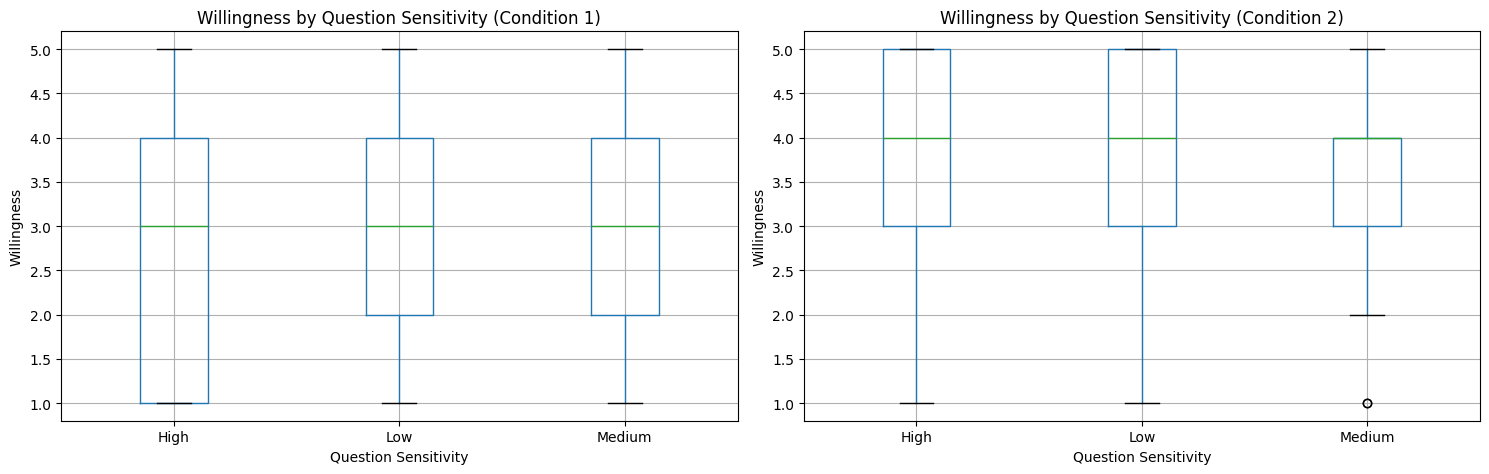

In [75]:
#  Now for by question_sensitivity
fig3, axes3 = plt.subplots(1, 2, figsize=(15, 5))
# Boxplot for willingness by question sensitivity for condition 1
df[df['condition'] == 1].boxplot(column='user_willingness', by='question_sensitivity', ax=axes3[0])
axes3[0].set_title('Willingness by Question Sensitivity (Condition 1)')
axes3[0].set_xlabel('Question Sensitivity')
axes3[0].set_ylabel('Willingness')
# Boxplot for willingness by question sensitivity for condition 2
df[df['condition'] == 2].boxplot(column='user_willingness', by='question_sensitivity', ax=axes3[1])
axes3[1].set_title('Willingness by Question Sensitivity (Condition 2)')
axes3[1].set_xlabel('Question Sensitivity')
axes3[1].set_ylabel('Willingness')
axes3[0].get_figure().suptitle('')

plt.tight_layout()
plt.show()